# ARPA Weather Station Data
This notebook is used for:
1) testing ARPA API functionalities
2) testing functions to be implemented in the plugin
3) testing libraries to be used and evaluate performances

First, it is necessary to get a token.
Go to Open Data Lombardia website (https://dati.lombardia.it/). Subscribe to the website and go to your profile settings. <br>
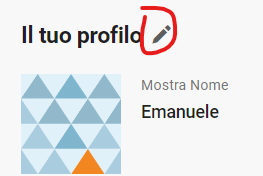 <br>
Modify your profile and open the "Opzioni per lo sviluppatore" tab. Create a new App Token to be used.


Useful notebook for Sodapy: https://github.com/xmunoz/sodapy/blob/master/examples/soql_queries.py

# TO-DO
- add a filter by province. donne with dask or done later it's fine?

## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sodapy import Socrata
import pandas as pd
from datetime import datetime, timedelta
import requests
from io import BytesIO
from zipfile import ZipFile
import os
import time
import numpy as np
import dask.dataframe as dd
import ipywidgets as widgets

In [2]:
import ARPA_functions as f
%load_ext autoreload
%autoreload 2

## Client

In [3]:
arpa_token = "riTLzYVRVdDaQtUkxDDaHRgJi" 
#arpa_token = "" 
print(arpa_token)
client = f.connect_ARPA_api(arpa_token)

riTLzYVRVdDaQtUkxDDaHRgJi
Using provided token.


Pandas va installato anche se si installa prima Dask

Function to create a client session with the API using the token:

## Stations and sensors information

Get all weather sensors information:

In [4]:
stationsId = "nf78-nj6b" # Select meteo stations dataset containing positions and information about sensors
sensors_info = client.get_all(stationsId)

Create sensors dataframe of sensors information:

In [5]:
sensors_df = f.ARPA_sensors_info(sensors_info)
sensors_df.head()

,idsensore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,datastop
0,10373,Precipitazione,mm,687,Ferno v.Di Dio,215,VA,2007-08-13,N,5051773,481053,8.756970445453431,45.61924377994763,"{'latitude': '45.61924377994763', 'longitude':...",NaT
1,10376,Precipitazione,mm,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",NaT
2,10377,Temperatura,°C,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",NaT
3,10381,Umidità Relativa,%,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",NaT
4,10382,Radiazione Globale,W/m²,706,Lecco v.Sora,272,LC,2008-07-31,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",NaT


Create a widget for selecting the sensor type:

In [6]:
unique_sensors_list = sensors_df['tipologia'].unique()
sw = widgets.Dropdown(
    options=unique_sensors_list,
    value='Temperatura',
    description='Sensor type:')
sw

Dropdown(description='Sensor type:', index=1, options=('Precipitazione', 'Temperatura', 'Umidità Relativa', 'R…

Select the sensor type:

In [7]:
sensor_sel = sw.value
sensor_sel

'Temperatura'

Create a list of sensors that belong to the selected sensor type:

In [8]:
sensors_list = (sensors_df.loc[sensors_df['tipologia'] == sensor_sel]).idsensore.tolist()  #& (sensors_df['storico'] == storic_data)
sensors_list_str = list(map(str, sensors_list))
sensors_provinces = sensors_df.groupby('provincia')['idsensore'].apply(list).to_frame().reset_index() #sensors lists grouped by province

In [9]:
sensors_provinces = sensors_df.groupby('provincia')['idsensore'].apply(list).to_frame().reset_index()

Consideration: inside the plugin the data type for each columns must be set accordingly to QGIS data types.

Select sensor type and create a list of those sensors from the previous dataframe.

In [10]:
print(("Selected sensor: {sel}").format(sel=sensor_sel))
print(("Number of selected sensor: {sens_len}").format(sens_len=len(sensors_list)))

Selected sensor: Temperatura
Number of selected sensor: 248


## Define Dates

In [11]:
start_date_str = "2019-01-01 00:00:00"
end_date_str = "2019-12-31 23:50:00"

year, start_date, end_date = f.check_dates(start_date_str, end_date_str)
year, start_date, end_date

(2019,
 datetime.datetime(2019, 1, 1, 0, 0),
 datetime.datetime(2019, 12, 31, 23, 50))

----

## Check API valid dates

Following function is used to obtain minimum and maximum date available in ARPA API.

In [12]:
start_date_API, end_date_API = f.req_ARPA_start_end_date_API(client)

The data from the API are available from:  2023-01-01 00:00:00  up to:  2023-01-30 12:00:00 . Select data in this range if you want to use API data.


---

## Download and process observations from API or csv files

The following code block will check if the chosen start date is before the start date available in the API.
If if the date is before that date, the csv file corresponding to the selected year will be downloaded and processed.

In [13]:
#If the chosen start date is before the start date available in the API -> use csv data
if start_date < start_date_API:
    sensors_values = f.download_extract_csv_from_year(str(year)) #download the csv corresponding to the selected year
    csv_file = str(year)+'.csv'
    sensors_values = f.process_ARPA_csv(csv_file, start_date, end_date, sensors_list) #process csv file with dask
    
#If the chosen start date is equal or after the start date of API -> request data from API
elif start_date >= start_date_API:
    print("Using API values")
    sensors_values = f.req_ARPA_data_API(client, start_date, end_date, sensors_list) #request data from ARPA API

--- Starting download ---
Downloaded: 259.64 MB
Starting unzipping: meteo_2019.zip
File unzipped: meteo_2019.zip
File csv saved: 2019.csv
meteo_2019.zip removed
--- Starting processing csv data ---
The time range used for the processing is 2019-01-01 00:00:00 to 2019-12-31 23:50:00
Starting computing dataframe
Time used for computing dataframe 18.17 s.


In [14]:
sensors_values

,idsensore,data,valore
0,2001,2019-01-01 00:00:00,3.4
1,9938,2019-01-01 00:00:00,0.7
2,10377,2019-01-01 00:00:00,3.7
3,10469,2019-01-01 00:00:00,1.8
4,10551,2019-01-01 00:00:00,1.0
...,...,...,...
317524,8096,2019-12-31 23:50:00,4.7
317525,8104,2019-12-31 23:50:00,7.4
317526,8123,2019-12-31 23:50:00,0.3
317527,8007,2019-12-31 23:50:00,12.6


## Filter values

### Filter by province

### Filter outliers

Define functions for filtering:
- zscore
- 3 times std ADD THIS?
- iqr

In [15]:
sensors_values

,idsensore,data,valore
0,2001,2019-01-01 00:00:00,3.4
1,9938,2019-01-01 00:00:00,0.7
2,10377,2019-01-01 00:00:00,3.7
3,10469,2019-01-01 00:00:00,1.8
4,10551,2019-01-01 00:00:00,1.0
...,...,...,...
317524,8096,2019-12-31 23:50:00,4.7
317525,8104,2019-12-31 23:50:00,7.4
317526,8123,2019-12-31 23:50:00,0.3
317527,8007,2019-12-31 23:50:00,12.6


In [16]:
outlier_methods = ['iqr', 'zscore']

In [17]:
checkboxes = [widgets.Checkbox(value=False, description=label) for label in outlier_methods]
output = widgets.VBox(children=checkboxes)
display(output)

In [62]:
selected_data = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selected_data = selected_data + [checkboxes[i].description]
print(selected_data)

['iqr']


In [63]:
if 'iqr' in selected_data:
    sensors_values = sensors_values.groupby('idsensore').apply(f.outlier_filter_iqr)
    print('Removed outliers using IQR')
if 'zscore' in selected_data:
    sensors_values = f.outlier_filter_zscore(sensors_values, sensors_list)
    print('Removed outliers using zscore')

Removed outliers using IQR


## Data aggregation

Function to aggregate the data in the dataframe. Both API and csv data can be aggregated.
Must provide a dataframe with idsensore (int), data (datetime), valore (float).
- Temporal aggregation: day, month, year etc.
- Aggregation function: mean, max, min etc.
- Sensor id aggregation (idsensore)

Use the function to aggregate and group the data. You can pass the value obtained from the API or the values obtaines from the csv.

In [64]:
sensor_test_agg = f.aggregate_group_data(sensors_values, "D", "mean")

Number of sensors available in the dataframe:  194
Aggregation function: mean
Temporal aggregation: D


In [65]:
sensor_test_agg

,idsensore,data,valore,count
0,115,2019-01-01,3.136806,144
1,115,2019-01-02,-5.300694,144
2,115,2019-01-03,-8.206944,144
3,115,2019-01-04,-6.407639,144
4,115,2019-01-05,-0.527083,144
...,...,...,...,...
69642,32401,2019-12-27,0.994444,144
69643,32401,2019-12-28,-0.927778,144
69644,32401,2019-12-29,1.984028,144
69645,32401,2019-12-30,2.830556,144


REMOVE OBSERVATION AGGREGATED WITH LESS THAN A GIVEN NUMBERS OF VALUES FOR MEAN CALCULATION?

## Join sensors information and time series 
Once the dataframes are created is possible to merge the information.

In [66]:
merged_df = pd.merge(sensor_test_agg, sensors_df, on='idsensore')
merged_df = f.order_dates(merged_df)
merged_df.head()

,idsensore,data,valore,count,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,datastop
0,115,2019-01-01,3.136806,144,Temperatura,°C,58,Carona Lago Fregabolgia,1955,BG,2001-12-01,N,5097125,566799,9.863057198828766,46.02443987306136,"{'latitude': '46.02443987306136', 'longitude':...",NaT
1,4042,2019-01-01,1.441667,144,Temperatura,°C,145,Darfo Boario Terme,222,BS,2002-12-04,N,5080789,591371,10.17735680898138,45.87460210989037,"{'latitude': '45.87460210989037', 'longitude':...",NaT
2,14399,2019-01-01,2.069444,144,Temperatura,°C,1365,Bione,911,BS,2012-11-18,N,5057931,603395,10.32736288461117,45.667218260274865,"{'latitude': '45.667218260274865', 'longitude'...",NaT
3,14445,2019-01-01,2.159441,143,Temperatura,°C,1366,Porlezza torrente,291,CO,2013-05-10,N,5098254,510895,9.140799377952803,46.03777316988709,"{'latitude': '46.03777316988709', 'longitude':...",NaT
4,4034,2019-01-01,1.450000,144,Temperatura,°C,144,Madesimo Spluga,1915,SO,2000-11-19,N,5146513,526726,9.348122957946567,46.4716582729432,"{'latitude': '46.4716582729432', 'longitude': ...",NaT


In [67]:
measure_unit = merged_df['unit_dimisura'].unique()[0]
print("Measure unit: "+measure_unit)

Measure unit: °C


# Plotting

In [68]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import matplotlib.dates as mdates
import seaborn as sns

### Plot all sensors

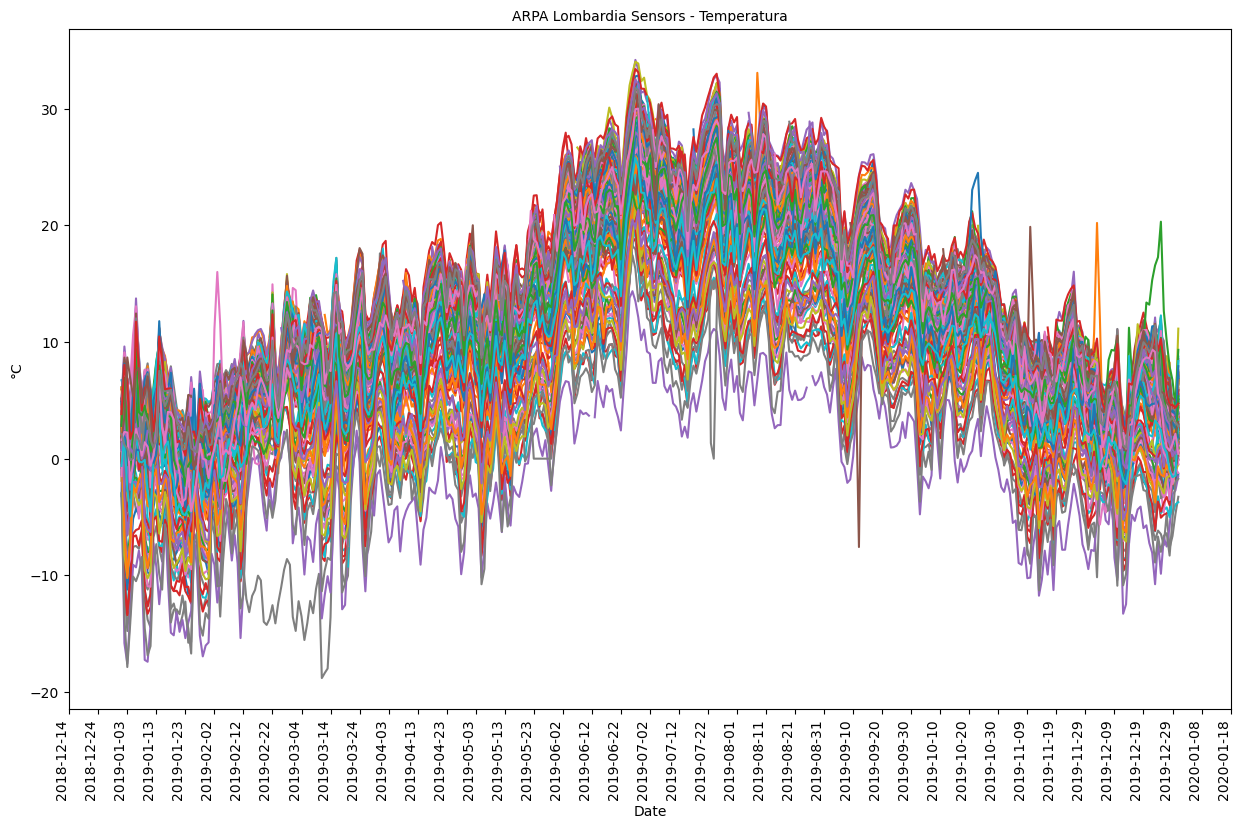

In [69]:
# Create a new figure
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('ARPA Lombardia Sensors - '+ sensor_sel,fontdict = {'fontsize': 10})
ax.set_ylabel(measure_unit,fontdict = {'fontsize': 10})
ax.set_xlabel('Date',fontdict = {'fontsize': 10})
# Iterate over the sensor IDs
for sensor_id in sensors_list:
    # Get the data for the current sensor
    sensor_data = merged_df[merged_df['idsensore'] == sensor_id]
    # Plot the time series for the sensor
    ax.plot(sensor_data['data'], sensor_data['valore'], label=sensor_id)

# # Add a legend to the plot
# ax.legend()

# Show the plot
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.show()

In [70]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

#   print(sel_sensor_min)
#     print(merged_df.loc[merged_df['idsensore'] == 17573])

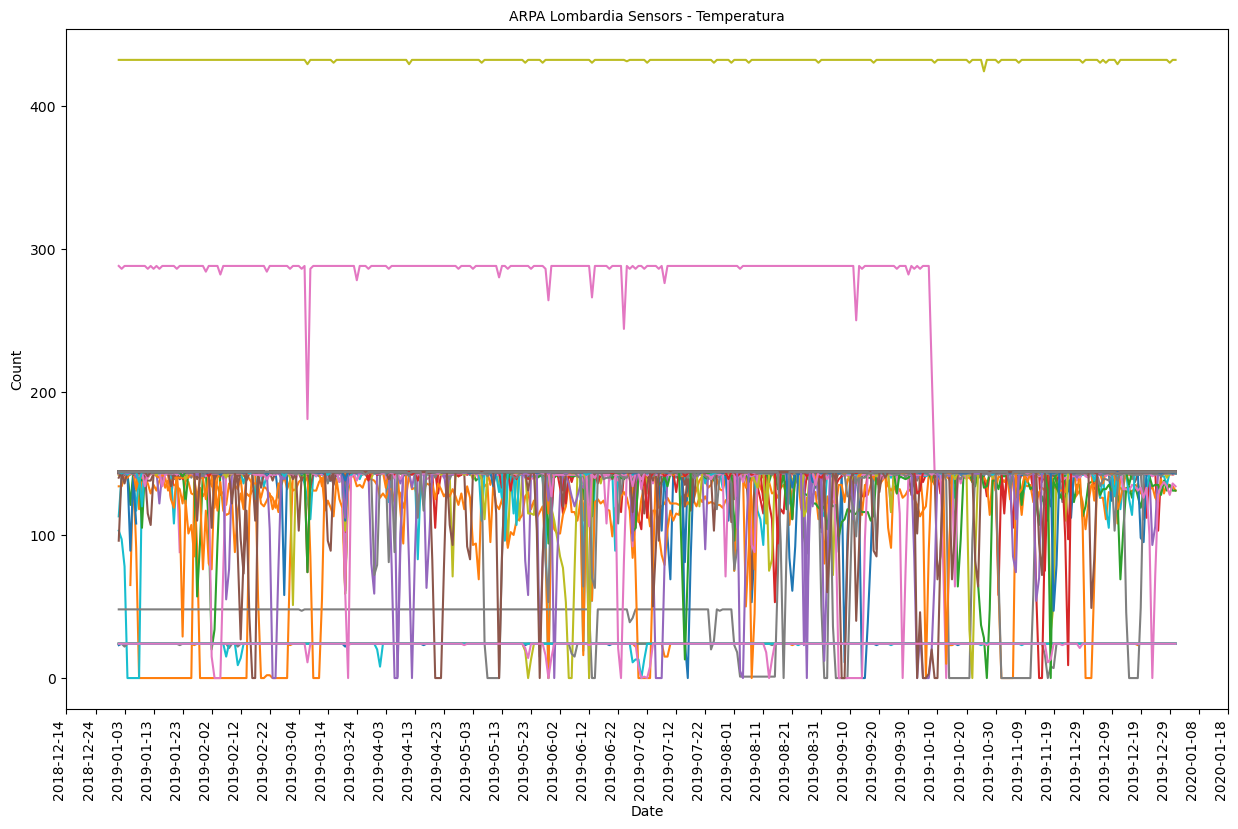

In [71]:
# Create a new figure
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('ARPA Lombardia Sensors - '+ sensor_sel,fontdict = {'fontsize': 10})
ax.set_ylabel('Count',fontdict = {'fontsize': 10})
ax.set_xlabel('Date',fontdict = {'fontsize': 10})
# Iterate over the sensor IDs
for sensor_id in sensors_list:
    # Get the data for the current sensor
    sensor_data = merged_df[merged_df['idsensore'] == sensor_id]
    # Plot the time series for the sensor
    ax.plot(sensor_data['data'], sensor_data['count'], label=sensor_id)

# # Add a legend to the plot
# ax.legend()

# Show the plot
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.show()

### Check highest and lowest values

Select the sensor that provide the lowest value in the dataframe to check if there are possible errors:

In [72]:
min_index = merged_df['valore'].idxmin()
idsensor_min = merged_df.loc[min_index].idsensore
sel_sensor_min = merged_df.loc[merged_df['idsensore']==idsensor_min]
data_min = merged_df.loc[min_index]['data']
merged_df.loc[min_index]

idsensore                                                    11144
data                                           2019-03-11 00:00:00
valore                                                  -18.816668
count                                                          144
tipologia                                              Temperatura
unit_dimisura                                                   °C
idstazione                                                     143
nomestazione                                Livigno Passo Foscagno
quota                                                         2320
provincia                                                       SO
datastart                                      2011-09-08 00:00:00
storico                                                          N
cgb_nord                                                   5149692
cgb_est                                                     592662
lng                                              10.2074885479

Select the sensor that provide the highest value in the dataframe:

In [73]:
max_index = merged_df['valore'].idxmax()
idsensor_max = merged_df.loc[max_index].idsensore
sel_sensor_max = merged_df.loc[merged_df['idsensore']==idsensor_max]
data_max = merged_df.loc[max_index]['data']
merged_df.loc[max_index]

idsensore                                                     5909
data                                           2019-06-27 00:00:00
valore                                                   34.202084
count                                                          144
tipologia                                              Temperatura
unit_dimisura                                                   °C
idstazione                                                     502
nomestazione                                       Milano v.Juvara
quota                                                          122
provincia                                                       MI
datastart                                      1989-01-01 00:00:00
storico                                                          N
cgb_nord                                                   5035546
cgb_est                                                     517377
lng                                              9.22231513873

In [74]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(sel_sensor_max)

Plot min and max selected sensors:

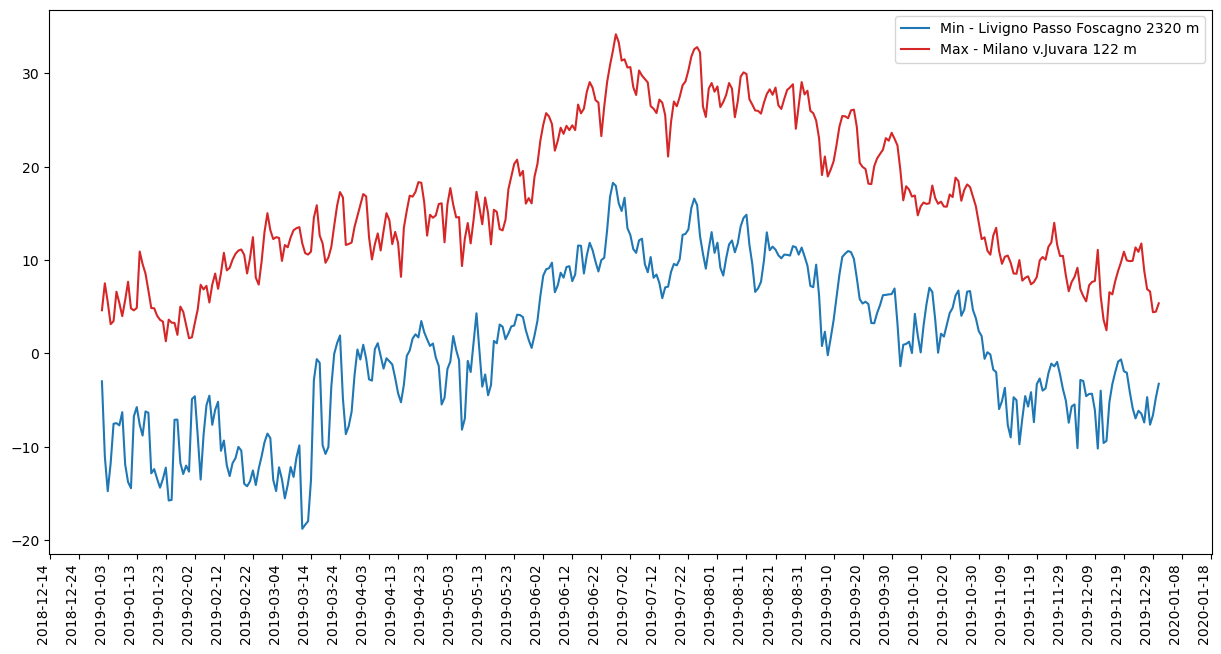

In [75]:
plt.figure(figsize=(15,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.plot(sel_sensor_min['data'],sel_sensor_min['valore'], '-',  color="tab:blue", label=("Min - {nome} {quota} m").format(nome=sel_sensor_min["nomestazione"].unique()[0], quota=sel_sensor_min["quota"].unique()[0]))
plt.plot(sel_sensor_max['data'],sel_sensor_max['valore'], '-',  color="tab:red", label=("Max - {nome} {quota} m").format(nome=sel_sensor_max["nomestazione"].unique()[0], quota=sel_sensor_max["quota"].unique()[0]))
plt.legend()

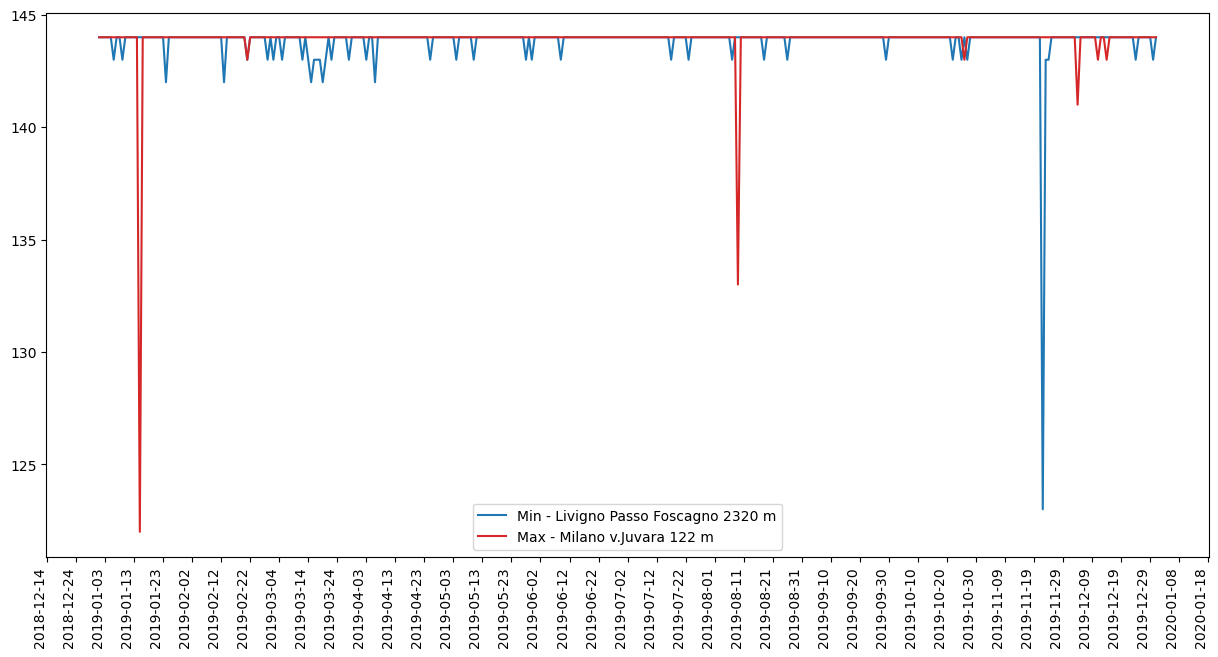

In [76]:
plt.figure(figsize=(15,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.plot(sel_sensor_min['data'],sel_sensor_min['count'], '-',  color="tab:blue", label=("Min - {nome} {quota} m").format(nome=sel_sensor_min["nomestazione"].unique()[0], quota=sel_sensor_min["quota"].unique()[0]))
plt.plot(sel_sensor_max['data'],sel_sensor_max['count'], '-',  color="tab:red", label=("Max - {nome} {quota} m").format(nome=sel_sensor_max["nomestazione"].unique()[0], quota=sel_sensor_max["quota"].unique()[0]))
plt.legend()

### Box Plot

Text(1, 36.202083587646484, 'ID: 11144, Quota: 2320 m\n Livigno Passo Foscagno')

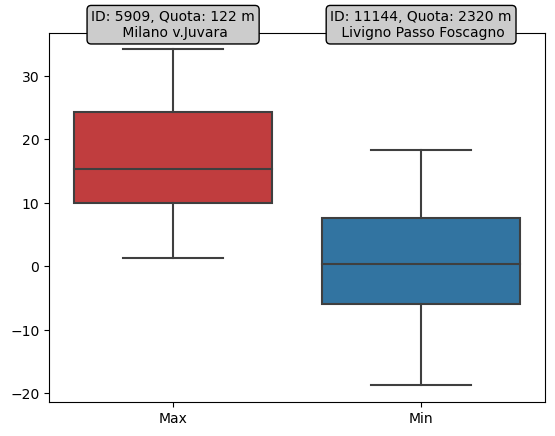

In [77]:
my_pal = {0: "tab:red", 1: "tab:blue"}
box = sns.boxplot(data=[sel_sensor_max['valore'], sel_sensor_min['valore']], orient="v", palette=my_pal)
plt.xticks([0, 1],["Max","Min"])
box.annotate(("ID: {id}, Quota: {quota} m\n {nome}").format(id=sel_sensor_max["idsensore"].unique()[0],
             quota=sel_sensor_max["quota"].unique()[0], nome=sel_sensor_max["nomestazione"].unique()[0]),
             xy=(0, sel_sensor_max['valore'].max()+2),
             horizontalalignment='center',
             bbox=dict(boxstyle="round", fc="0.8"))
box.annotate(("ID: {id}, Quota: {quota} m\n {nome}").format(id=sel_sensor_min["idsensore"].unique()[0],
             quota=sel_sensor_min["quota"].unique()[0], nome=sel_sensor_min["nomestazione"].unique()[0]),
             xy=(1, sel_sensor_max['valore'].max()+2),
             horizontalalignment='center',
             bbox=dict(boxstyle="round", fc="0.8"))

### Map

In [78]:
import geopandas as gpd 

Import Lombardy and CMM vector files:

In [79]:
lombardy_gdf = gpd.read_file('lombardia_boundary.gpkg')
cmm_gdf = gpd.read_file('CMM.gpkg')

### Filter by province

In [80]:
# provinces = list(sensors_provinces.provincia)

# prov_w = widgets.Dropdown(
#     options=provinces,
#     value='MI',
#     description='Province:')
# prov_w

In [81]:
# prov_value = prov_w.value
# prov_value

In [82]:
# selected_sensors_prov = sensors_provinces.loc[sensors_provinces['provincia'] == prov_value]['idsensore']
# selected_sensors_prov = selected_sensors_prov.to_list()[0]

Convert to Geodataframe:

In [83]:
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.cgb_est, merged_df.cgb_nord), crs="EPSG:32632")

In [84]:
# gdf = gdf.loc[gdf['idsensore'].isin(selected_sensors_prov)]

In [85]:
gdf.head()

,idsensore,data,valore,count,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,datastop,geometry
0,115,2019-01-01,3.136806,144,Temperatura,°C,58,Carona Lago Fregabolgia,1955,BG,2001-12-01,N,5097125,566799,9.863057198828766,46.02443987306136,"{'latitude': '46.02443987306136', 'longitude':...",NaT,POINT (566799.000 5097125.000)
1,4042,2019-01-01,1.441667,144,Temperatura,°C,145,Darfo Boario Terme,222,BS,2002-12-04,N,5080789,591371,10.17735680898138,45.87460210989037,"{'latitude': '45.87460210989037', 'longitude':...",NaT,POINT (591371.000 5080789.000)
2,14399,2019-01-01,2.069444,144,Temperatura,°C,1365,Bione,911,BS,2012-11-18,N,5057931,603395,10.32736288461117,45.667218260274865,"{'latitude': '45.667218260274865', 'longitude'...",NaT,POINT (603395.000 5057931.000)
3,14445,2019-01-01,2.159441,143,Temperatura,°C,1366,Porlezza torrente,291,CO,2013-05-10,N,5098254,510895,9.140799377952803,46.03777316988709,"{'latitude': '46.03777316988709', 'longitude':...",NaT,POINT (510895.000 5098254.000)
4,4034,2019-01-01,1.450000,144,Temperatura,°C,144,Madesimo Spluga,1915,SO,2000-11-19,N,5146513,526726,9.348122957946567,46.4716582729432,"{'latitude': '46.4716582729432', 'longitude': ...",NaT,POINT (526726.000 5146513.000)


Filter on the dates corresponding to the max and min values found before:

In [86]:
min_date = merged_df.loc[min_index].data
max_date =merged_df.loc[max_index].data

In [87]:
min_date, max_date

(Timestamp('2019-03-11 00:00:00'), Timestamp('2019-06-27 00:00:00'))

In [88]:
max_gdf = gdf.loc[merged_df['data'] == max_date]
min_gdf = gdf.loc[merged_df['data'] == min_date]

In [89]:
min_point = min_gdf.loc[min_gdf['idsensore'] == idsensor_min]
max_point = max_gdf.loc[max_gdf['idsensore'] == idsensor_max]

Text(0.5, 173.14773259505725, 'East [m]')

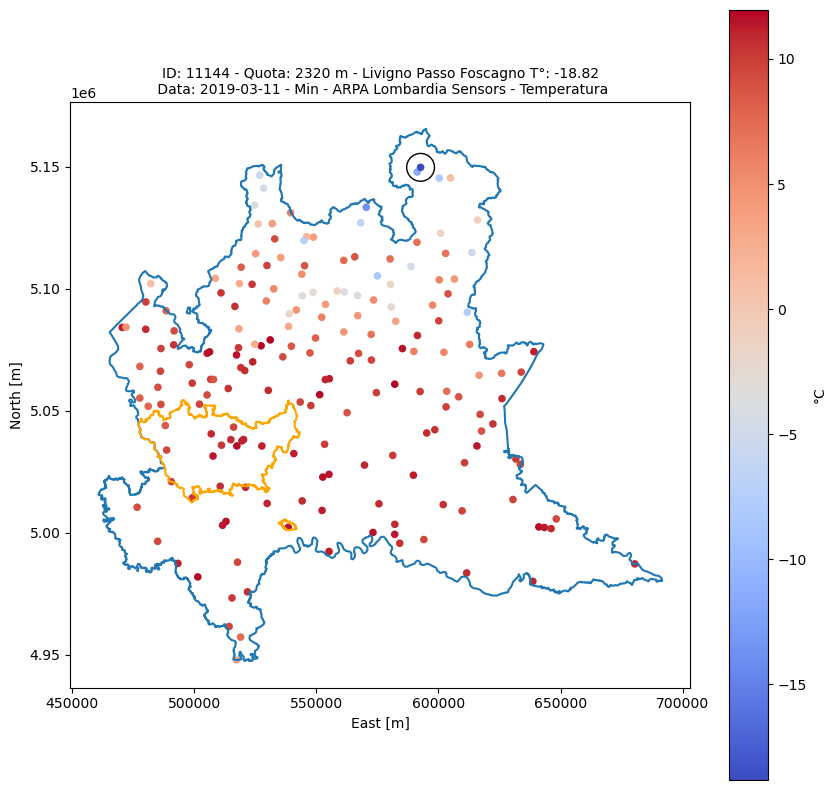

In [90]:
fig, ax = plt.subplots(figsize = (10,10))
min_gdf.plot(ax=ax, markersize=20, column='valore', legend=True, cmap='coolwarm', legend_kwds={'label': measure_unit ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
min_point.plot(ax=ax, marker='o', markersize=400, color='black',facecolors='none')
ax.set_title(("ID: {id} - Quota: {quota} m - {nome} T°: {minT:0.2f}\n Data: {data} - Min - ARPA Lombardia Sensors - {sensor_sel}").format(id=sel_sensor_min["idsensore"].unique()[0],
             quota=sel_sensor_min["quota"].unique()[0], nome=sel_sensor_min["nomestazione"].unique()[0], minT=sel_sensor_min['valore'].min(),
             data=data_min.strftime("%Y-%m-%d"), sensor_sel=sensor_sel), fontdict = {'fontsize': 10})
ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

Text(0.5, 173.14773259505725, 'East [m]')

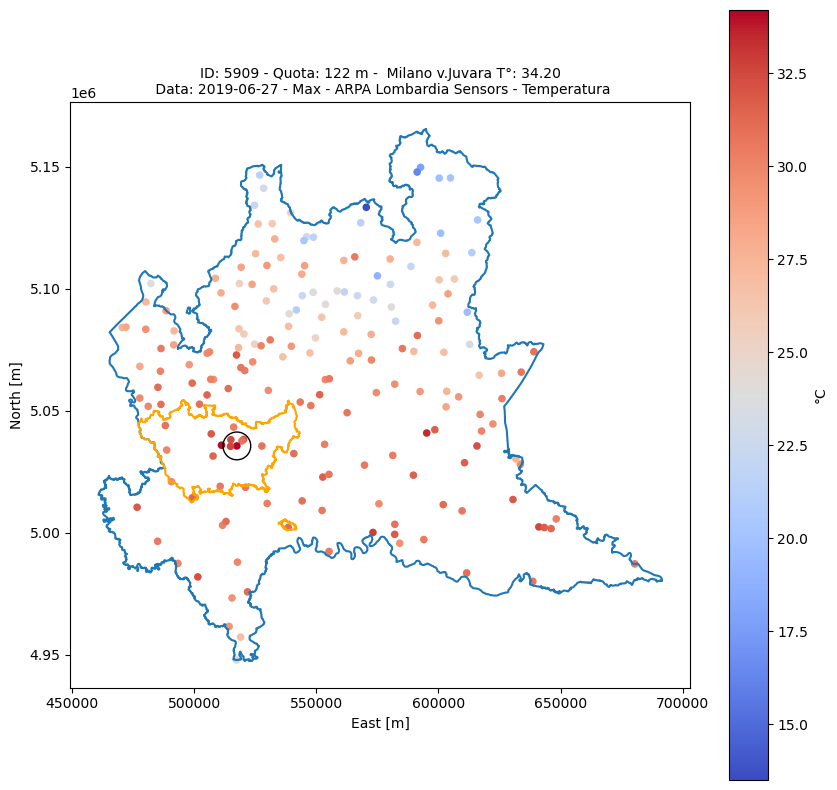

In [91]:
fig, ax = plt.subplots(figsize = (10,10))
max_gdf.plot(ax=ax, markersize=20, column='valore', legend=True, cmap='coolwarm', legend_kwds={'label': measure_unit ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
max_point.plot(ax=ax, marker='o', markersize=400, color='black',facecolors='none')
ax.set_title(("ID: {id} - Quota: {quota} m -  {nome} T°: {maxT:0.2f}\n Data: {data} - Max - ARPA Lombardia Sensors - {sensor_sel}").format(id=sel_sensor_max["idsensore"].unique()[0],
             quota=sel_sensor_max["quota"].unique()[0], nome=sel_sensor_max["nomestazione"].unique()[0], maxT=sel_sensor_max['valore'].max(),
             data=data_max.strftime("%Y-%m-%d"), sensor_sel=sensor_sel), fontdict = {'fontsize': 10})

ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

Text(0.5, 173.14773259505725, 'East [m]')

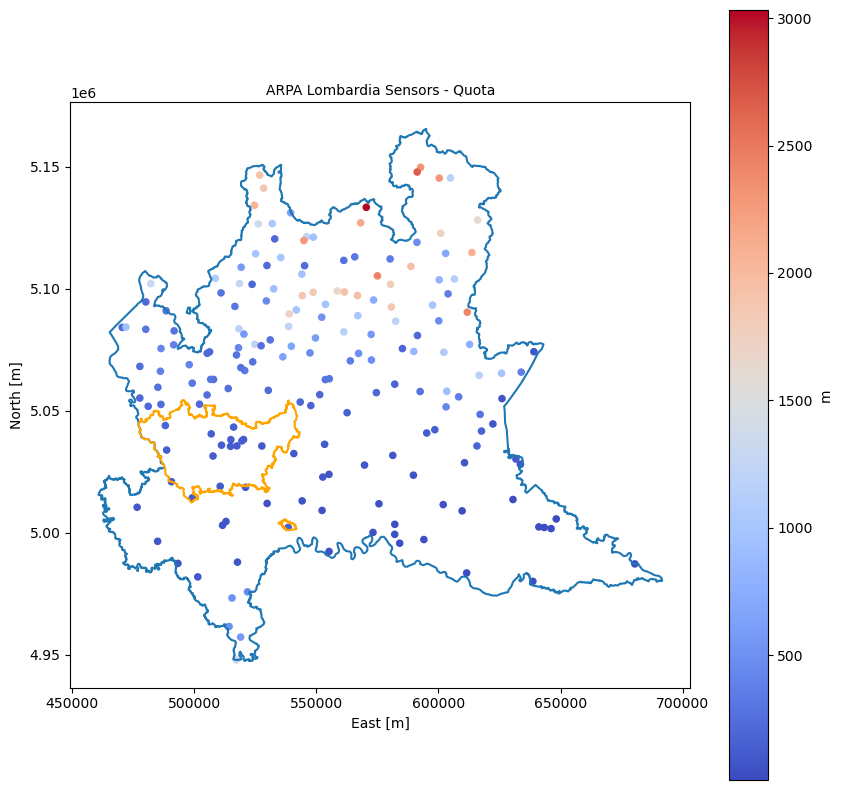

In [92]:
fig, ax = plt.subplots(figsize = (10,10))
max_gdf.plot(ax=ax, markersize=20, column='quota', legend=True, cmap='coolwarm', legend_kwds={'label': 'm' ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
ax.set_title('ARPA Lombardia Sensors - Quota',fontdict = {'fontsize': 10})
ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

In [93]:
gdf_test = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.lng, merged_df.lat), crs="EPSG:4326")

In [94]:
gdf_test.dtypes

idsensore                 int64
data             datetime64[ns]
valore                  float32
count                     int64
tipologia              category
unit_dimisura            object
idstazione                int32
nomestazione             object
quota                     int16
provincia              category
datastart        datetime64[ns]
storico                category
cgb_nord                 object
cgb_est                  object
lng                      object
lat                      object
location                 object
datastop         datetime64[ns]
geometry               geometry
dtype: object

In [95]:
gdf_test

,idsensore,data,valore,count,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,datastop,geometry
0,115,2019-01-01,3.136806,144,Temperatura,°C,58,Carona Lago Fregabolgia,1955,BG,2001-12-01,N,5097125,566799,9.863057198828766,46.02443987306136,"{'latitude': '46.02443987306136', 'longitude':...",NaT,POINT (9.86306 46.02444)
1,4042,2019-01-01,1.441667,144,Temperatura,°C,145,Darfo Boario Terme,222,BS,2002-12-04,N,5080789,591371,10.17735680898138,45.87460210989037,"{'latitude': '45.87460210989037', 'longitude':...",NaT,POINT (10.17736 45.87460)
2,14399,2019-01-01,2.069444,144,Temperatura,°C,1365,Bione,911,BS,2012-11-18,N,5057931,603395,10.32736288461117,45.667218260274865,"{'latitude': '45.667218260274865', 'longitude'...",NaT,POINT (10.32736 45.66722)
3,14445,2019-01-01,2.159441,143,Temperatura,°C,1366,Porlezza torrente,291,CO,2013-05-10,N,5098254,510895,9.140799377952803,46.03777316988709,"{'latitude': '46.03777316988709', 'longitude':...",NaT,POINT (9.14080 46.03777)
4,4034,2019-01-01,1.450000,144,Temperatura,°C,144,Madesimo Spluga,1915,SO,2000-11-19,N,5146513,526726,9.348122957946567,46.4716582729432,"{'latitude': '46.4716582729432', 'longitude': ...",NaT,POINT (9.34812 46.47166)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69642,5920,2019-12-31,3.493750,144,Temperatura,°C,503,Milano P.zza Zavattari,122,MI,1989-01-01,N,5035847,511082,9.141786267186658,45.47606340509791,"{'latitude': '45.47606340509791', 'longitude':...",NaT,POINT (9.14179 45.47606)
69643,9026,2019-12-31,3.657639,144,Temperatura,°C,1233,Lurago Marinone,296,CO,2004-01-01,N,5061268,499092,8.98833547049708,45.704965032524214,"{'latitude': '45.704965032524214', 'longitude'...",NaT,POINT (8.98834 45.70497)
69644,9025,2019-12-31,1.838194,144,Temperatura,°C,1228,Goito,30,MN,2004-03-11,N,5013581,630514,10.663595357934602,45.2636105457828,"{'latitude': '45.2636105457828', 'longitude': ...",NaT,POINT (10.66360 45.26361)
69645,14348,2019-12-31,1.344755,143,Temperatura,°C,1359,Breno Lago Della Vacca,2410,BS,2012-12-09,N,5090337,611798,10.442716428689312,45.957496834144656,"{'latitude': '45.957496834144656', 'longitude'...",NaT,POINT (10.44272 45.95750)


In [96]:
min_gdf["lat"] = [float(str(i).replace(",", "")) for i in min_gdf["lat"]]
min_gdf["lng"] = [float(str(i).replace(",", "")) for i in min_gdf["lng"]]

In [97]:
max_gdf["lat"] = [float(str(i).replace(",", "")) for i in max_gdf["lat"]]
max_gdf["lng"] = [float(str(i).replace(",", "")) for i in max_gdf["lng"]]

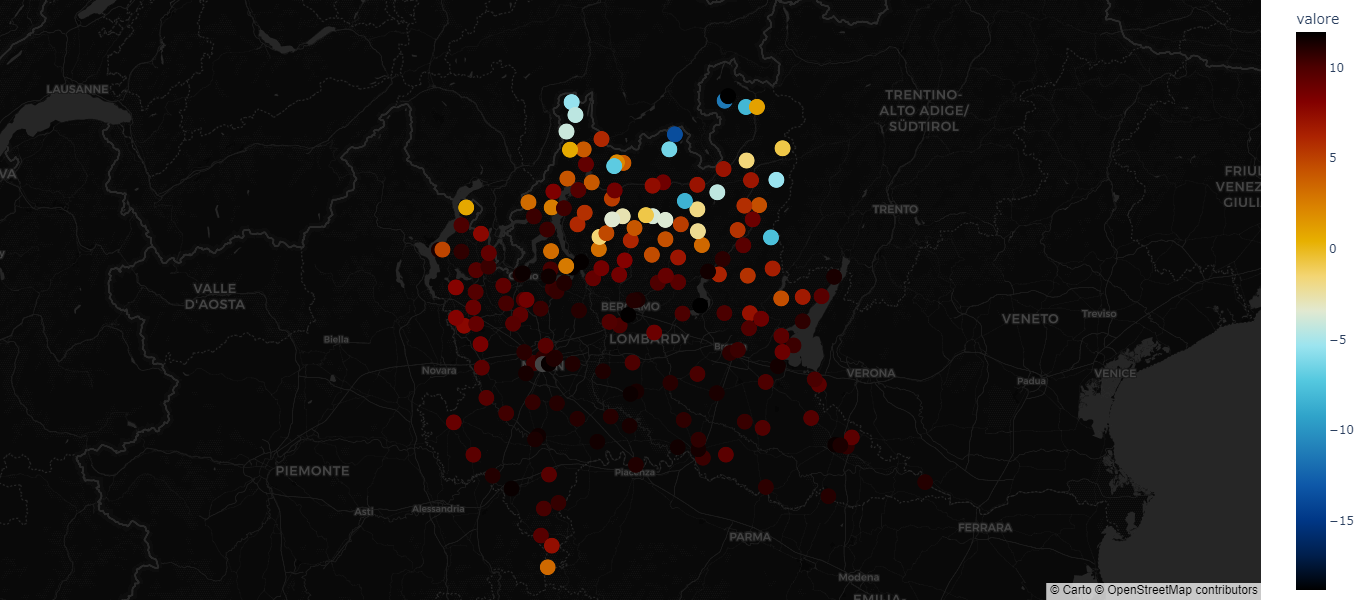

In [98]:
#using plotly for an animated choropleth map
import plotly.express as px
fig = px.scatter_mapbox(min_gdf,
                        lat="lat",
                        lon="lng",
                        hover_name="idsensore",
                        hover_data=["nomestazione","provincia","valore"],
                        color="valore",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=7,
                        height=600,
                        size='lat',
                        size_max=12,
                        opacity=1,
                        width=900)
fig.update_layout(mapbox_style='carto-darkmatter')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

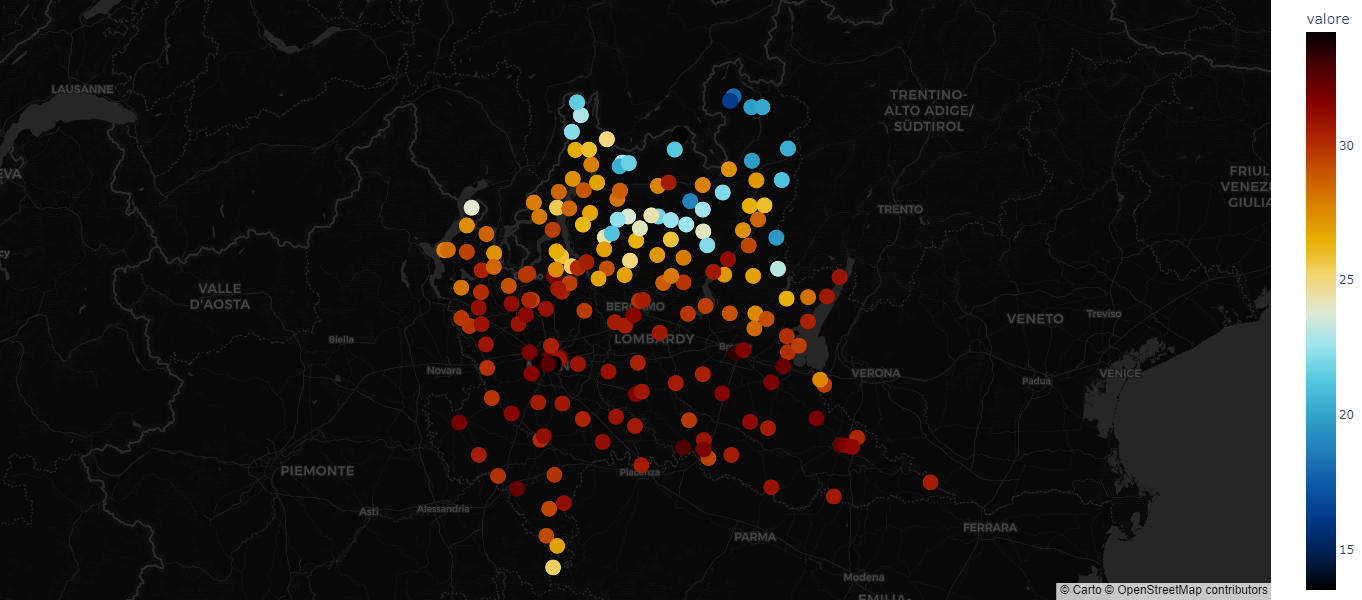

In [99]:
fig = px.scatter_mapbox(max_gdf,
                        lat="lat",
                        lon="lng",
                        hover_name="idsensore",
                        hover_data=["nomestazione","provincia","valore"],
                        color="valore",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=7,
                        height=600,
                        size='lat',
                        size_max=12,
                        opacity=1,
                        width=900)
fig.update_layout(mapbox_style='carto-darkmatter')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

Interactive map (use a small geodataframe)

In [100]:
# gdf_test = gdf
# gdf_test['data'] = gdf_test['data'].astype(str)
# gdf_test = gdf_test.drop(['datastart','datastop'], axis=1)
# m = gdf_test.explore(
#      column="valore",  # make choropleth based on "BoroName" column
#      cmap='OrRd',
#      scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
#      legend=True, # show legend
#      k=10, # use 10 bins
#      legend_kwds=dict(colorbar='OrRd'), # do not use colorbar
#      name="stations") # name of the layer in the map

# lombardy_gdf.explore(m=m,
#                     style_kwds=dict(fill=False))

## Other useful functions

In [101]:
# def remove_csv_file(filename):
#     if os.path.exists(filename):
#         print("Csv file removed from folder")
#         os.remove(filename)
#     else:
#         print("The file does not exist")

In [58]:
# remove_csv_file(csv_file)

In [59]:
# from scipy import stats

# def zscore_filter(df, zscore_tr=3):

#     grouped = df.groupby('idsensore')
    
#     # for each group, calculate the z-scores and remove the outliers
#     for name, group in grouped:
#         df['z_scores'] = stats.zscore(group['valore'], nan_policy='omit')
#         df = df[(df['idsensore'] != name) | (df['z_scores'].abs() <= zscore_tr)]
 
#     return df

In [60]:
# # backup 
#     #Create list of sensor integer
#     sens_list = list(map(int, sens_list_str))
    
#     #Create sensors list formatted for query
#     ids_str = ""
#     for i in sens_list:
#         ids_str += f"\'{str(i)}\',"
#     ids_str = ids_str[:-1]
#     ids_str += ""
    
#     #Select the Open Data Lombardia Meteo sensors dataset
#     weather_sensor_id = "647i-nhxk"
    
#     #Convert to string in year-month-day format, accepted by ARPA query
#     start_date = start_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
#     end_date = end_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    
#     print("--- Starting request to ARPA API ---")
    
#     t = time.time()
    
#     #Query data
#     query = """
#       select
#           *
#       where data >= \'{}\' and data <= \'{}\' and idsensore in ({}) limit 9999999999999999
#       """.format(start_date, end_date, ids_str)